In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.model_selection import cross_val_score

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [3]:
autos = pd.read_csv("/datasets/autos.csv")

In [4]:
autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
autos.columns = autos.columns.str.lower()

In [6]:
autos = autos.rename(columns={'datecrawled': 'date_crawled',
                              'vehicletype': 'vehicle_type',
                              'registrationyear': 'registration_year',
                              'registrationmonth': 'registration_month',
                              'fueltype': 'fuel_type',
                              'datecreated': 'date_created',
                              'numberofpictures': 'number_of_pictures',
                              'postalcode': 'postal_code',
                              'lastseen': 'last_seen'})

In [7]:
autos.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [8]:
autos.duplicated().sum()

4

In [9]:
autos = autos.drop_duplicates()

In [10]:
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [11]:
print('Доля пропусков в vehicle_type: {:.2%}'.format(autos['vehicle_type'].isna().mean()))
print('Доля пропусков в gearbox: {:.2%}'.format(autos['gearbox'].isna().mean()))
print('Доля пропусков в model: {:.2%}'.format(autos['model'].isna().mean()))
print('Доля пропусков в fuel_type: {:.2%}'.format(autos['fuel_type'].isna().mean()))
print('Доля пропусков в repaired: {:.2%}'.format(autos['repaired'].isna().mean()))

Доля пропусков в vehicle_type: 10.58%
Доля пропусков в gearbox: 5.60%
Доля пропусков в model: 5.56%
Доля пропусков в fuel_type: 9.28%
Доля пропусков в repaired: 20.08%


Больше всего пустых значений в столбцах **vehicle_type, fuel_type** и **repaired**

In [12]:
autos.vehicle_type.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [13]:
autos.vehicle_type.fillna('other', inplace = True)

In [14]:
autos.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [15]:
autos.fuel_type.fillna('other', inplace = True)

In [16]:
autos.repaired.unique()

array([nan, 'yes', 'no'], dtype=object)

In [17]:
autos.repaired.fillna('unknown', inplace = True)

In [18]:
autos.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

In [19]:
autos.gearbox.fillna('unknown', inplace = True)

In [20]:
autos.model.fillna('unknown', inplace = True)

In [21]:
autos.fuel_type.value_counts()

petrol      216349
gasoline     98719
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: fuel_type, dtype: int64

**petrol** и **gasoline** означает бензин, так что это можно объединить 

In [22]:
autos['fuel_type'] = autos['fuel_type'].replace(['gasoline'], 'petrol')

In [23]:
autos.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [24]:
autos = autos.drop(['date_crawled', 'registration_month', 
                    'date_created', 'number_of_pictures', 
                    'postal_code', 'last_seen'], axis = 1)

In [25]:
autos['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [26]:
autos = autos.loc[(autos['registration_year'] <= 2016) & (autos['registration_year'] >= 1900)]

In [27]:
autos.power.value_counts()

0       36453
75      22806
60      15169
150     14150
101     12732
        ...  
1704        1
2729        1
1703        1
3750        1
903         1
Name: power, Length: 699, dtype: int64

In [28]:
autos = autos.loc[(autos['power'] <= 700) & (autos['power'] != 0)]

In [29]:
power_med = autos['power'].median()

In [30]:
autos['power'] = autos['power'].replace(0, power_med)

0        6402
500      4473
1500     4430
1200     3737
2500     3707
         ... 
19870       1
11410       1
10898       1
3991        1
8188        1
Name: price, Length: 3592, dtype: int64

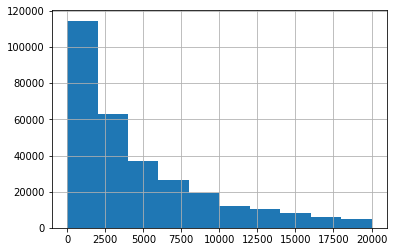

In [31]:
autos.price.hist()
autos.price.value_counts()

In [32]:
autos = autos.loc[autos['price'] > 0]

In [33]:
autos.duplicated().sum()

39816

In [34]:
autos = autos.drop_duplicates().reset_index(drop=True)

In [35]:
autos.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
1,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
5,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
6,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
7,999,small,1998,manual,101,golf,150000,other,volkswagen,unknown
8,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
9,2799,wagon,2005,manual,140,passat,150000,petrol,volkswagen,yes




<div class="alert alert-block alert-info">
<b>Совет[2]:</b>  Вопрос на подумать: Как думаешь а машины с 0-ой мощностью могут быть просто без двигателя?
</div>

### Вывод

В рамках этого раздела мы провели предобработку данных. Мы перевели названия столбцов в более удобочитаемый змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий и удалили дубликаты

## Обучение моделей

In [36]:
data = pd.get_dummies(autos, drop_first = True)
data.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
target_ohe = data['price']
features_ohe = data.drop('price', axis = 1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, 
                                                                                           target_ohe, 
                                                                                           test_size = 0.25, 
                                                                                           random_state = 42) 
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(192582, 307)
(64195, 307)


In [38]:
data_nums = list(data)
data_nums.remove('price')
print(data_nums)

['registration_year', 'power', 'kilometer', 'vehicle_type_convertible', 'vehicle_type_coupe', 'vehicle_type_other', 'vehicle_type_sedan', 'vehicle_type_small', 'vehicle_type_suv', 'vehicle_type_wagon', 'gearbox_manual', 'gearbox_unknown', 'model_145', 'model_147', 'model_156', 'model_159', 'model_1_reihe', 'model_1er', 'model_200', 'model_2_reihe', 'model_300c', 'model_3_reihe', 'model_3er', 'model_4_reihe', 'model_500', 'model_5_reihe', 'model_5er', 'model_601', 'model_6_reihe', 'model_6er', 'model_7er', 'model_80', 'model_850', 'model_90', 'model_900', 'model_9000', 'model_911', 'model_a1', 'model_a2', 'model_a3', 'model_a4', 'model_a5', 'model_a6', 'model_a8', 'model_a_klasse', 'model_accord', 'model_agila', 'model_alhambra', 'model_almera', 'model_altea', 'model_amarok', 'model_antara', 'model_arosa', 'model_astra', 'model_auris', 'model_avensis', 'model_aveo', 'model_aygo', 'model_b_klasse', 'model_b_max', 'model_beetle', 'model_berlingo', 'model_bora', 'model_boxster', 'model_bra

Масштабируем признаки 

In [39]:
# scaler = StandardScaler()
# scaler.fit(features_train_ohe[data_nums])
# features_train_ohe[data_nums] = scaler.transform(features_train_ohe[data_nums])
# features_test_ohe[data_nums] = scaler.transform(features_test_ohe[data_nums])
# При запуске этого кода вылетает ошибка и смерть ядра

### Модель линейной регрессии

In [40]:
model = LinearRegression()
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

cv_scores = cross_val_score(
    model, 
    features_train_ohe, 
    target_train_ohe,
    scoring=rmse_scorer,
    cv=5
)

print(f"RMSE (кросс-валидация):' {cv_scores.mean()}")

RMSE (кросс-валидация):' 2714.3296142236854


### Модель решающего дерева

In [41]:
target_oe = autos['price']
features_oe = autos.drop('price', axis=1)
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, 
                                                                                        target_oe, 
                                                                                        test_size=0.25, 
                                                                                        random_state=42) 
print(features_train_oe.shape)
print(features_test_oe.shape)

(192582, 9)
(64195, 9)


In [42]:
categorical_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

enc = OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=-1                   
)
enc.fit(features_train_oe[categorical_cols])

features_train_oe[categorical_cols] = enc.transform(features_train_oe[categorical_cols])
features_test_oe[categorical_cols] = enc.transform(features_test_oe[categorical_cols])

/tmp/ipykernel_82/494962424.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_oe[categorical_cols] = enc.transform(features_train_oe[categorical_cols])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_82/494962424.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [43]:
%%time
for depth in range(3, 19, 3):
    model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    scores = cross_val_score(
        model, 
        features_train_oe, 
        target_train_oe, 
        scoring='neg_mean_squared_error',  # возвращает -MSE
        cv=5
    )
    rmse = np.mean(np.sqrt(-scores))  # усредняем RMSE по фолдам
    print(f"Глубина: {depth}, RMSE (кросс-валидация): {rmse:.2f}")

Глубина: 3, RMSE (кросс-валидация): 2998.96
Глубина: 6, RMSE (кросс-валидация): 2319.01
Глубина: 9, RMSE (кросс-валидация): 2064.14
Глубина: 12, RMSE (кросс-валидация): 1967.17
Глубина: 15, RMSE (кросс-валидация): 1990.15
Глубина: 18, RMSE (кросс-валидация): 2047.01
CPU times: user 9.47 s, sys: 0 ns, total: 9.47 s
Wall time: 9.5 s


### Модель случайного леса 

In [44]:
%%time
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)
model = RandomForestRegressor(
    random_state=42, 
    n_estimators=100, 
    max_depth=9
)
cv_scores = cross_val_score(
    model, 
    features_train_oe, 
    target_train_oe, 
    scoring=rmse_scorer, 
    cv=5 
)
print("Средний RMSE:", cv_scores.mean())

Средний RMSE: 1979.4736192539797
CPU times: user 1min 35s, sys: 0 ns, total: 1min 35s
Wall time: 1min 36s


### LightGBM

In [45]:
!pip install lightgbm

In [46]:
import lightgbm 
print(lightgbm.__version__)

3.3.1


In [47]:
target = autos['price']
features = autos.drop('price', axis=1)

for c in features.columns:
    col_type = features[c].dtype
    if col_type == 'object':
        features[c] = features[c].astype('category')
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.25, 
                                                                            random_state=42) 

print(features_train.shape)
print(features_test.shape)

(192582, 9)
(64195, 9)


In [48]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse)
model = lgb.LGBMRegressor(random_state=42)

cv_scores = cross_val_score(
    model,
    features_train, 
    target_train,
    scoring=rmse_scorer,
    cv=5,  
    n_jobs=-1,
)
print("Средний RMSE:", cv_scores.mean())

Средний RMSE: 1656.9071408129566


## Анализ моделей

### Линейная регрессия

In [49]:
%%time 
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

CPU times: user 14.3 s, sys: 2.82 s, total: 17.1 s
Wall time: 17.2 s


LinearRegression()

In [50]:
%%time
predictions_train = model.predict(features_train_ohe)

CPU times: user 278 ms, sys: 361 ms, total: 639 ms
Wall time: 594 ms


### Модель решающего дерева

In [51]:
%%time
model = DecisionTreeRegressor(random_state=42, max_depth=9)
model.fit(features_train_oe, target_train_oe)

CPU times: user 381 ms, sys: 30.9 ms, total: 412 ms
Wall time: 444 ms


DecisionTreeRegressor(max_depth=9, random_state=42)

In [52]:
%%time
predictions_train = model.predict(features_train_oe)

CPU times: user 22 ms, sys: 3.33 ms, total: 25.3 ms
Wall time: 23.4 ms


### Модель случайного леса

In [53]:
%%time
model = RandomForestRegressor(random_state=42, max_depth=9, n_estimators=1000)
model.fit(features_train_oe, target_train_oe)

CPU times: user 4min 1s, sys: 252 ms, total: 4min 1s
Wall time: 4min 2s


RandomForestRegressor(max_depth=9, n_estimators=1000, random_state=42)

In [ ]:
%%time
predictions_train = model.predict(features_train_oe)

###  Модель LightGBM

In [ ]:
%%time 
model = lgb.LGBMRegressor(random_state=42, n_estimators=500, num_leaves=160)
model.fit(features_train, target_train)

CPU times: user 47.6 s, sys: 434 ms, total: 48 s
Wall time: 48.8 s


LGBMRegressor(n_estimators=500, num_leaves=160, random_state=42)

In [56]:
%%time
predictions_train = model.predict(features_train)

CPU times: user 25.3 s, sys: 0 ns, total: 25.3 s
Wall time: 25.6 s


Наилучшей моделью по метрике RMSE является LightGBM, но в то же время данная модель обучается дольше всего

In [57]:
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print(rmse)

1568.1483031407176


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

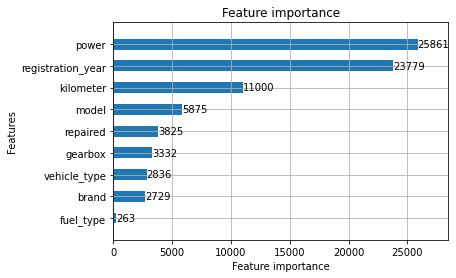

In [58]:
lgb.plot_importance(model, height=.5)

Можно выделить 3 самых важных признака - **power**, **registration year** и **model**, влияющих на цену 

## Общий вывод

1) Мы получили датафрейм с 350 тыс. строк и 16 столбцами, провели работу с названиями столбцов (привели к змеиному регистру), очистили данные от пробелов и дубликатов. 

2) Мы перевели категориальные значения столбцов в количественные. Для моделей решающего дерева и случайного леса применили порядковое кодирование из-за чего подбор гиперпараметров стал быстрее. Мы обучили разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами **'n_estimators': 500**, **'num_leaves': 240** дает наименьшее значение **RMSE: 1383.85** 

3) Если оценивать скорость работы, то дольше всего обучается модель случайного леса. Обучение модели LightGBM занимает 50 секунд и имеет наилучший показатель RMSE

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей